# Audio Classifier for Cats and Dogs sounds

### Importing libraries...

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
import torchvision
from torchvision import datasets, models, transforms
from scipy.io import wavfile
import numpy as np
import pandas as pd
import librosa
import IPython.display as ipd
from IPython.display import display
from pathlib import Path
import matplotlib.pyplot as plt
import os
import time
import copy

plt.ion()

In [3]:
Path.cwd()

PosixPath('/content')

### Importing Data...

In [4]:
root=Path("/gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Audio_Classifier")
Input_Dir = root/"cats_dogs_data"
Train_Audio_Dir = Input_Dir/"train"
Test_Audio_Dir = Input_Dir/"test"

In [5]:
train_df=pd.read_csv(root/"train.csv")
test_df=pd.read_csv(root/"test.csv")

In [6]:
a=Train_Audio_Dir/"cat"
b=Train_Audio_Dir/"dog"
c=Test_Audio_Dir/"cat"
d=Test_Audio_Dir/"dog"

l1=[filename for filename in a.iterdir()]
for filename in b.iterdir():
    l1.append(filename)
l2=[filename for filename in c.iterdir()]
for filename in d.iterdir():
    l2.append(filename)
train_df["full_address"]=l1
test_df["full_address"]=l2

In [7]:
train_df

audio_filename  ...                                       full_address
0             cat_1.wav  ...  /gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Au...
1            cat_10.wav  ...  /gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Au...
2           cat_100.wav  ...  /gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Au...
3           cat_101.wav  ...  /gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Au...
4           cat_102.wav  ...  /gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Au...
..                  ...  ...                                                ...
205  dog_barking_94.wav  ...  /gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Au...
206  dog_barking_95.wav  ...  /gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Au...
207  dog_barking_96.wav  ...  /gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Au...
208  dog_barking_97.wav  ...  /gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Au...
209  dog_barking_98.wav  ...  /gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Au...

[210 rows x 4 columns]

In [8]:
test_df

audio_filename  ...                                       full_address
0          cat_110.wav  ...  /gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Au...
1          cat_112.wav  ...  /gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Au...
2          cat_115.wav  ...  /gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Au...
3          cat_126.wav  ...  /gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Au...
4          cat_129.wav  ...  /gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Au...
..                 ...  ...                                                ...
62  dog_barking_89.wav  ...  /gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Au...
63   dog_barking_9.wav  ...  /gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Au...
64  dog_barking_90.wav  ...  /gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Au...
65  dog_barking_91.wav  ...  /gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Au...
66  dog_barking_99.wav  ...  /gdrive/MyDrive/dev/ML Projects/Cats_&_Dogs_Au...

[67 rows x 4 columns]

### Creating spectrograms for input audio files...

In [9]:
melspectrogram_parameters = {
    "n_mels": 64,
    "fmin": 20,
    "fmax": 32000
}

In [10]:
class_names = ["cat", "dog"]
rev_class_names = {"cat":0, "dog":1}
my_dict = {'train':train_df, 'val':test_df}


def mono_to_color(X: np.ndarray,
                  mean=None,
                  std=None,
                  norm_max=None,
                  norm_min=None,
                  eps=1e-6):
    """
    Code from https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data
    """
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V


class AudioDataset(data.Dataset):
    def __init__(self, df: pd.DataFrame, img_size=224, melspectrogram_parameters={}):
        self.df = df
        self.img_size = img_size
        self.melspectrogram_parameters = melspectrogram_parameters
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx: int):
        SR = 16000
        sample = self.df.loc[idx, :]
        row_id = rev_class_names[sample.type]
        addr = str(sample.full_address)
        
        s,w=wavfile.read(addr)
        y = w.astype(np.float32)
        melspec = librosa.feature.melspectrogram(y,sr=SR,
                                                 **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)
        image = mono_to_color(melspec)
        data_transforms=transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.RandomCrop(224)])
        image = data_transforms(image)
        image = np.array(image)
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)
        return image, row_id, addr

##### Looking at a sample spectrogram...

In [11]:
def audio_to_image(filename, SR=16000):
    s,w=wavfile.read(filename)
    y = w.astype(np.float32)
    melspec = librosa.feature.melspectrogram(y,sr=SR,
                                             **melspectrogram_parameters)
    melspec = librosa.power_to_db(melspec).astype(np.float32)
    image = mono_to_color(melspec)
    data_transforms = transforms.Compose([transforms.ToPILImage(),
                                          transforms.Resize(256),
                                          transforms.RandomCrop(224)])
    image = data_transforms(image)
    image = np.array(image)
    image = np.moveaxis(image, 2, 0)
    image = (image).astype(np.uint8)
    return image

/usr/local/lib/python3.6/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


<class 'numpy.ndarray'>
(3, 224, 224)
[179 179 179]


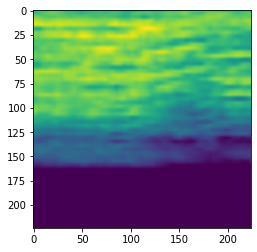

In [12]:
x=audio_to_image(Train_Audio_Dir/"cat/cat_99.wav")
print(type(x))
print(x.shape)
plt.imshow(x[0,:,:])
print(x.transpose((1, 2, 0))[40][40])

### Defining Datasets and Dataloaders...

In [13]:
audio_data = {x: AudioDataset(my_dict[x], melspectrogram_parameters=melspectrogram_parameters)
              for x in ["train", "val"]}
dataloaders = {x: data.DataLoader(audio_data[x], batch_size=4, shuffle=True)
              for x in ["train", "val"]}
dataset_sizes = {x: len(audio_data[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
dataset_sizes

{'train': 210, 'val': 67}

/usr/local/lib/python3.6/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


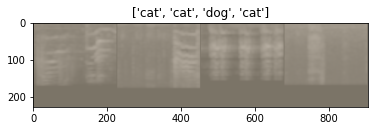

type:cat
________________________________________


type:cat
________________________________________


type:dog
________________________________________


type:cat
________________________________________


In [15]:
def imshow(inp, title=None):             #function to show spectrogram
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes, filenames = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

for i in range(inputs.size()[0]):
    a = ipd.Audio(filenames[i])
    display(a)
    print('type:{}'.format(class_names[classes[i]]))
    print('_'*40)

### Defining training and evaluation models...

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses =[]
    val_losses =[]
    train_acc =[]
    val_acc =[]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase=='train':
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    a = np.arange(num_epochs) + 1
    fig, ax = plt.subplots(1,2)
    ax[0].plot(a, train_losses, a, val_losses)
    ax[0].legend(labels=["train_loss","val_loss"])
    ax[1].plot(a, train_acc, a, val_acc)
    ax[1].legend(labels=["train_acc","val_acc"])

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels, filenames) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                a = ipd.Audio(filenames[(images_so_far-1)%inputs.size()[0]])
                display(a)
                print('predicted: {}'.format(class_names[preds[j]]))
                print('_'*50)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [18]:
model_conv = torchvision.models.resnet18(pretrained=True) #using a pretrained resnet18 model
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


##### training the model...

Epoch 1/10
----------


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


train Loss: 0.8047 Acc: 0.5524
val Loss: 0.5721 Acc: 0.6866

Epoch 2/10
----------
train Loss: 0.6102 Acc: 0.6667
val Loss: 0.5027 Acc: 0.8209

Epoch 3/10
----------
train Loss: 0.4862 Acc: 0.7952
val Loss: 0.4784 Acc: 0.7910

Epoch 4/10
----------
train Loss: 0.5664 Acc: 0.6762
val Loss: 0.3992 Acc: 0.8507

Epoch 5/10
----------
train Loss: 0.5254 Acc: 0.7286
val Loss: 0.3615 Acc: 0.8806

Epoch 6/10
----------
train Loss: 0.4597 Acc: 0.8095
val Loss: 0.3553 Acc: 0.8955

Epoch 7/10
----------
train Loss: 0.4495 Acc: 0.7905
val Loss: 0.3553 Acc: 0.8507

Epoch 8/10
----------
train Loss: 0.4272 Acc: 0.8048
val Loss: 0.3442 Acc: 0.8657

Epoch 9/10
----------
train Loss: 0.3939 Acc: 0.8190
val Loss: 0.3471 Acc: 0.8507

Epoch 10/10
----------
train Loss: 0.4097 Acc: 0.8000
val Loss: 0.3424 Acc: 0.8806

Training complete in 3m 24s
Best val Acc: 0.895522


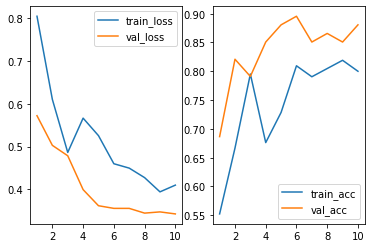

In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

##### predicting the model...

In [20]:
visualize_model(model_conv)

plt.ioff()
plt.show()

/usr/local/lib/python3.6/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


predicted: cat
__________________________________________________


predicted: cat
__________________________________________________


predicted: cat
__________________________________________________


predicted: cat
__________________________________________________


predicted: cat
__________________________________________________


predicted: cat
__________________________________________________
